In [68]:
import os
import re
import glob

import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import export_graphviz
from graphviz import Source

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# 1.

## Exploración de los datos

In [2]:
f = h5py.File("Datos/fof_subhalo_tab_099.0.hdf5", "r")


In [3]:
pos = np.array(f["Subhalo/SubhaloPos"][:])
sfr = np.array(f["Subhalo/SubhaloSFR"][:])
ids = np.array(f["Subhalo/SubhaloIDMostbound"][:])

# DataFrame de ejemplo
ex = pd.DataFrame({
    "ID": ids,
    "SFR": sfr,
    "X": pos[:, 0],
    "Y": pos[:, 1],
    "Z": pos[:, 2],
})
for key in f['Subhalo'].keys():
    if key not in ["SubhaloPos", "SubhaloSFR", "SubhaloIDMostbound"]:
        # Revisar dimensiones
        if len(f['Subhalo'][key][:].shape) == 1:
            data = np.array(f['Subhalo'][key][:])
            col_name = key.split("Subhalo")[-1]
            ex[col_name] = data
        else:
            print(f"⚠️  {key}, {f['Subhalo'][key][:].shape[1]}D data")

⚠️  SubhaloCM, 3D data
⚠️  SubhaloGasMetalFractions, 10D data
⚠️  SubhaloGasMetalFractionsHalfRad, 10D data
⚠️  SubhaloGasMetalFractionsMaxRad, 10D data
⚠️  SubhaloGasMetalFractionsSfr, 10D data
⚠️  SubhaloGasMetalFractionsSfrWeighted, 10D data
⚠️  SubhaloHalfmassRadType, 6D data
⚠️  SubhaloLenType, 6D data
⚠️  SubhaloMassInHalfRadType, 6D data
⚠️  SubhaloMassInMaxRadType, 6D data
⚠️  SubhaloMassInRadType, 6D data
⚠️  SubhaloMassType, 6D data
⚠️  SubhaloSpin, 3D data
⚠️  SubhaloStarMetalFractions, 10D data
⚠️  SubhaloStarMetalFractionsHalfRad, 10D data
⚠️  SubhaloStarMetalFractionsMaxRad, 10D data
⚠️  SubhaloStellarPhotometrics, 8D data
⚠️  SubhaloVel, 3D data


## a)

In [4]:
# Ordenamos archivos por índice numérico
def numeric_index(path):
    return int(re.findall(r'\.(\d+)\.hdf5$', path)[0])


files = glob.glob("Datos/fof_subhalo_tab_099.*.hdf5")
files = sorted(files, key=numeric_index)

all_fields = set()

for fpath in files:
    with h5py.File(fpath, "r") as f:
        if "Subhalo" in f:
            for key in f["Subhalo"].keys():
                all_fields.add(key)

all_fields = sorted(all_fields)
print("Campos encontrados:", all_fields)

data_chunks = {field: [] for field in all_fields}

for fpath in files:
    with h5py.File(fpath, "r") as f:
        if "Subhalo" not in f:
            continue

        g = f["Subhalo"]
        keys = list(g.keys())

        if len(keys) == 0:
            print(f"[WARNING] Subhalo vacio en: {fpath}, saltando.")
            continue

        ref_field = keys[0]
        nrows = len(g[ref_field])

        for field in all_fields:
            if field in g:
                data_chunks[field].append(g[field][:])
            else:
                arr = g[ref_field]
                if arr.ndim == 1:
                    missing = np.full(nrows, np.nan)
                else:
                    missing = np.full((nrows, arr.shape[1]), np.nan)

                data_chunks[field].append(missing)



# Juntar todos los fragmentos
final_data = {}
for field, chunks in data_chunks.items():
    final_data[field] = np.concatenate(chunks)


Campos encontrados: ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarM

In [5]:
# Construir DataFrame final
df = pd.DataFrame()

for field, arr in final_data.items():

    if arr.ndim == 1:
        df[field] = arr

    else:
        for i in range(arr.shape[1]):
            df[f"{field}_{i}"] = arr[:, i]


# Definimos IDs Subfind
df["SubhaloID"] = np.arange(len(df))

print(df.head())
print(df.shape)

/tmp/ipykernel_1726671/2860032548.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{field}_{i}"] = arr[:, i]
/tmp/ipykernel_1726671/2860032548.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{field}_{i}"] = arr[:, i]
/tmp/ipykernel_1726671/2860032548.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

   SubhaloBHMass  SubhaloBHMdot  SubhaloBfldDisk  SubhaloBfldHalo  \
0       0.579029   1.852354e-04         2.008474         0.172786   
1       0.054223   1.516171e-05         0.068316         0.069231   
2       0.029711   2.138259e-06         0.134068         0.303128   
3       0.020092   7.053461e-06         0.065826         0.120497   
4       0.019615   3.058788e-07         0.817195         0.807718   

   SubhaloCM_0   SubhaloCM_1   SubhaloCM_2  SubhaloFlag  \
0  7300.426270  24514.015625  21300.208984         True   
1  6812.355469  24896.800781  21219.810547         True   
2  6780.131348  23867.488281  21088.685547         True   
3  7322.278809  25125.027344  20773.980469         True   
4  7635.023438  24392.828125  21199.900391         True   

   SubhaloGasMetalFractions_0  SubhaloGasMetalFractions_1  ...  \
0                    0.740028                    0.250430  ...   
1                    0.680867                    0.277670  ...   
2                    0.697962   

/tmp/ipykernel_1726671/2860032548.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["SubhaloID"] = np.arange(len(df))


## b)

In [6]:
print("Total de propiedades:", len(df.columns))
for p in df.columns:
    print(p)

Total de propiedades: 169
SubhaloBHMass
SubhaloBHMdot
SubhaloBfldDisk
SubhaloBfldHalo
SubhaloCM_0
SubhaloCM_1
SubhaloCM_2
SubhaloFlag
SubhaloGasMetalFractions_0
SubhaloGasMetalFractions_1
SubhaloGasMetalFractions_2
SubhaloGasMetalFractions_3
SubhaloGasMetalFractions_4
SubhaloGasMetalFractions_5
SubhaloGasMetalFractions_6
SubhaloGasMetalFractions_7
SubhaloGasMetalFractions_8
SubhaloGasMetalFractions_9
SubhaloGasMetalFractionsHalfRad_0
SubhaloGasMetalFractionsHalfRad_1
SubhaloGasMetalFractionsHalfRad_2
SubhaloGasMetalFractionsHalfRad_3
SubhaloGasMetalFractionsHalfRad_4
SubhaloGasMetalFractionsHalfRad_5
SubhaloGasMetalFractionsHalfRad_6
SubhaloGasMetalFractionsHalfRad_7
SubhaloGasMetalFractionsHalfRad_8
SubhaloGasMetalFractionsHalfRad_9
SubhaloGasMetalFractionsMaxRad_0
SubhaloGasMetalFractionsMaxRad_1
SubhaloGasMetalFractionsMaxRad_2
SubhaloGasMetalFractionsMaxRad_3
SubhaloGasMetalFractionsMaxRad_4
SubhaloGasMetalFractionsMaxRad_5
SubhaloGasMetalFractionsMaxRad_6
SubhaloGasMetalFractionsM

In [7]:
# Columnas de interés
columns_keep = ['SubhaloGasMetallicity',
                'SubhaloMass',
                'SubhaloMassType_0',
                'SubhaloMassType_1',
                'SubhaloMassType_2',
                'SubhaloMassType_3',
                'SubhaloMassType_4',
                'SubhaloMassType_5',
                'SubhaloPos_0',
                'SubhaloPos_1',
                'SubhaloPos_2',
                'SubhaloSFR',
                'SubhaloSpin_0',
                'SubhaloSpin_1',
                'SubhaloSpin_2',
                'SubhaloStarMetallicity',
                'SubhaloVel_0',
                'SubhaloVel_1',
                'SubhaloVel_2',
                'SubhaloVelDisp',
                'SubhaloVmax',
                'SubhaloVmaxRad',
                'SubhaloWindMass',
                'SubhaloID'
                ]

# Quitamos subhalos con Flag = False
df = df[df['SubhaloFlag']]
df = df[[col for col in df.columns if col in columns_keep]]

## c)

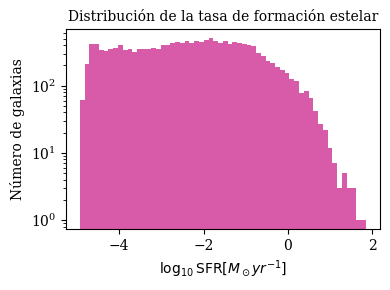

In [8]:
plt.figure(figsize=(4, 3))
mask = df['SubhaloSFR'] > 0
plt.hist(np.log10(df.loc[mask, 'SubhaloSFR']), bins=60, log=True, color="mediumvioletred", alpha=0.7)
plt.xlabel(r"$\log_{10} \mathrm{SFR} [M_\odot yr^{-1}]$")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la tasa de formación estelar")
plt.tight_layout()
plt.show()


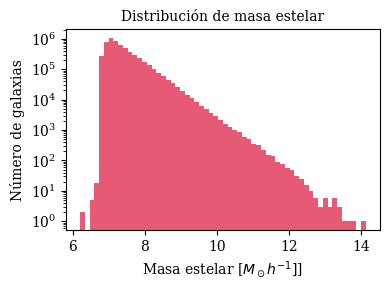

In [9]:
plt.figure(figsize=(4, 3))
plt.hist(np.log10(df['SubhaloMass'] * 1e10), bins=60, log=True, color="crimson", alpha=0.7)
plt.xlabel("Masa estelar [$M_\odot h^{-1}]$]")
plt.ylabel("Número de galaxias")
plt.title("Distribución de masa estelar")
plt.tight_layout()
plt.show()

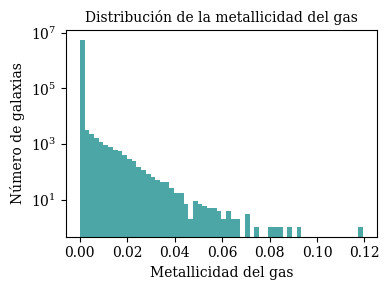

In [10]:
plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloGasMetallicity'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Metallicidad del gas")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la metallicidad del gas")
plt.tight_layout()
plt.show()

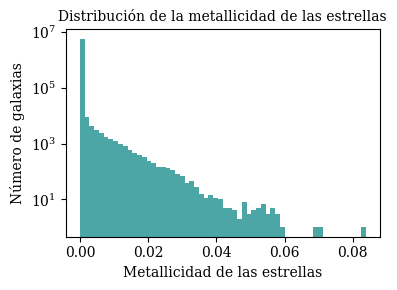

In [11]:
plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloStarMetallicity'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Metallicidad de las estrellas")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la metallicidad de las estrellas")
plt.tight_layout()
plt.show()

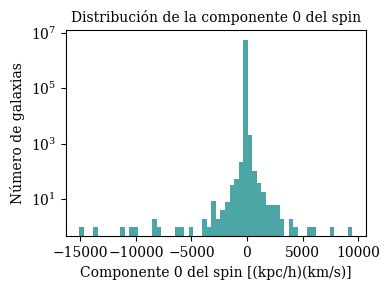

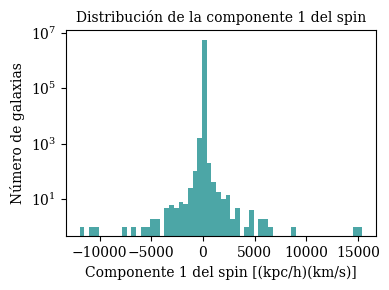

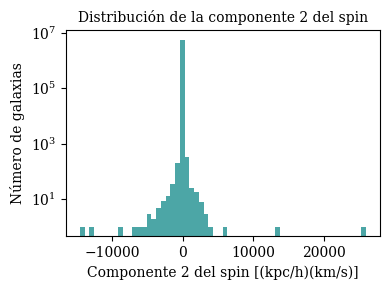

In [12]:
plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloSpin_0'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Componente 0 del spin [(kpc/h)(km/s)]")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la componente 0 del spin")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloSpin_1'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Componente 1 del spin [(kpc/h)(km/s)]")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la componente 1 del spin")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloSpin_2'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Componente 2 del spin [(kpc/h)(km/s)]")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la componente 2 del spin")
plt.tight_layout()
plt.show()

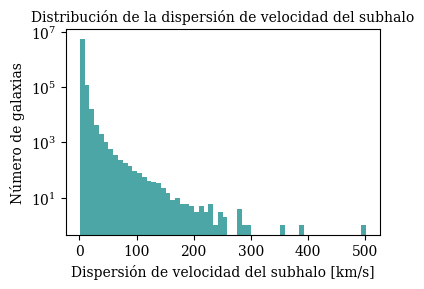

In [13]:
plt.figure(figsize=(4, 3))
plt.hist(df['SubhaloVelDisp'], bins=60, log=True, color="teal", alpha=0.7)
plt.xlabel("Dispersión de velocidad del subhalo [km/s]")
plt.ylabel("Número de galaxias")
plt.title("Distribución de la dispersión de velocidad del subhalo")
plt.tight_layout()
plt.show()

## d)

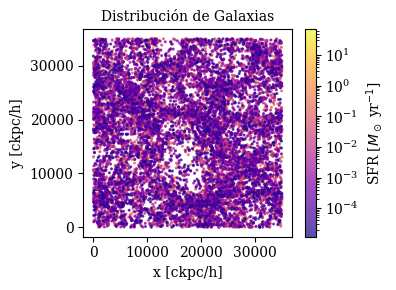

In [14]:
plt.figure(figsize=(4, 3))
sfr = df['SubhaloSFR']
mask = sfr > 0
x = df['SubhaloPos_0']
y = df['SubhaloPos_1']
sfr = sfr[mask]
x = x[mask]
y = y[mask]
sc = plt.scatter(
    x, y, c=sfr,
    s=1.5, cmap="plasma",
    norm=LogNorm(vmin=min(sfr), vmax=max(sfr)),
    alpha=0.7
)
plt.xlabel("x [ckpc/h]")
plt.ylabel("y [ckpc/h]")
plt.title("Distribución de Galaxias")
plt.colorbar(sc, label="SFR [$M_\\odot$ yr$^{-1}$]")
plt.axis("equal")
plt.tight_layout()
plt.show()

### Merge con Jellyfish

In [15]:
jf = h5py.File("Datos/jellyfish.hdf5", "r")['Snapshot_099']

In [16]:
jf = pd.DataFrame({
    "SubhaloID": jf["SubhaloIDs"][:],
    "ScoreAdjusted": jf["ScoreAdjusted"][:],
    "ScoreRaw": jf["ScoreRaw"][:],
    "ClassificationNumRaw": jf["ClassificationNumRaw"][:],
    "ClassificationNumAdjusted": jf["ClassificationNumAdjusted"][:],
    "expertNum": jf["expertNum"][:],
    "ScoreRawTotal": jf["ScoreRawTotal"][:],
})

In [17]:
df_merged = df.merge(
    jf,
    how="inner",
    on="SubhaloID"
)

In [18]:
df_merged

,SubhaloGasMetallicity,SubhaloMass,SubhaloMassType_0,SubhaloMassType_1,SubhaloMassType_2,SubhaloMassType_3,SubhaloMassType_4,SubhaloMassType_5,SubhaloPos_0,SubhaloPos_1,...,SubhaloVmax,SubhaloVmaxRad,SubhaloWindMass,SubhaloID,ScoreAdjusted,ScoreRaw,ClassificationNumRaw,ClassificationNumAdjusted,expertNum,ScoreRawTotal
0,0.030973,157.060089,0.227375,143.777634,0.0,0.0,13.025371,0.029711,6774.915527,23864.580078,...,354.704529,0.863242,0.0,2,0.064791,0.05,20.0,19.0,0.0,1.0
1,0.026935,31.240942,1.741229,26.965401,0.0,0.0,2.528330,0.005984,8070.635254,24389.376953,...,191.930206,0.951246,0.0,8,0.031838,0.05,20.0,20.0,0.0,1.0
2,0.034762,18.749269,0.673523,15.532797,0.0,0.0,2.539410,0.003540,7051.789551,23817.816406,...,164.306885,8.905804,0.0,11,0.878533,0.85,20.0,20.0,0.0,17.0
3,0.054017,16.190680,0.086507,13.610888,0.0,0.0,2.489373,0.003911,7731.748047,24314.457031,...,171.295380,8.767321,0.0,12,0.077787,0.20,20.0,20.0,6.0,4.0
4,0.016528,15.664657,0.553931,14.531116,0.0,0.0,0.577643,0.001967,6440.559570,24252.548828,...,129.189194,3.455755,0.0,17,0.063565,0.05,20.0,20.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412,0.009478,1.032192,0.070051,0.932277,0.0,0.0,0.029713,0.000151,8157.603027,33193.878906,...,66.680740,4.158565,0.0,727826,0.059520,0.05,20.0,19.0,0.0,1.0
1413,0.016909,1.141478,0.006954,1.114638,0.0,0.0,0.019802,0.000084,8376.555664,25888.294922,...,55.774853,4.519668,0.0,733422,0.062293,0.05,20.0,19.0,0.0,1.0
1414,0.015397,2.020072,0.145087,1.848356,0.0,0.0,0.026629,0.000000,5366.706055,6400.820801,...,64.223572,9.054040,0.0,734091,0.045806,0.15,20.0,18.0,0.0,3.0
1415,0.008570,1.561543,0.151737,1.376577,0.0,0.0,0.032981,0.000248,33406.449219,13711.583008,...,67.757835,5.632882,0.0,738605,0.066849,0.05,20.0,18.0,0.0,1.0


In [19]:
# Definimos como Jellyfish las filas con ScoreAdjusted >= 0.7
df_merged['isJellyfish'] = np.where(df_merged['ScoreAdjusted'] >= 0.7, 1, 0)

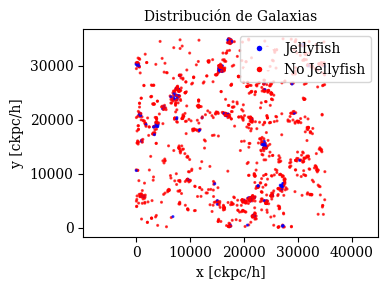

In [20]:
plt.figure(figsize=(4, 3))

x = df_merged['SubhaloPos_0']
y = df_merged['SubhaloPos_1']
isJf = df_merged['isJellyfish']

colors = np.where(isJf == 1, 'blue', 'red')

plt.scatter(x, y, c=colors, s=1.5, alpha=0.7)

plt.xlabel("x [ckpc/h]")
plt.ylabel("y [ckpc/h]")
plt.title("Distribución de Galaxias")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Jellyfish', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='No Jellyfish', markerfacecolor='red', markersize=5)
]
plt.legend(handles=legend_elements, loc='best')

plt.axis("equal")
plt.tight_layout()
plt.show()


# 2.

In [21]:
coord  = ['X', 'Y', 'Z']

rename_map = {}

for col in df_merged.columns:
    new = col

    if re.match(r".*_\d$", col):
        idx = int(col.split("_")[-1])
        if "Pos" in col or "Vel" in col or "Spin" in col or "CM" in col:
            new = col.replace(f"_{idx}", f"_{coord[idx]}")

    rename_map[col] = new

df_merged = df_merged.rename(columns=rename_map)


In [22]:
list(df_merged.columns) 

['SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloMassType_0',
 'SubhaloMassType_1',
 'SubhaloMassType_2',
 'SubhaloMassType_3',
 'SubhaloMassType_4',
 'SubhaloMassType_5',
 'SubhaloPos_X',
 'SubhaloPos_Y',
 'SubhaloPos_Z',
 'SubhaloSFR',
 'SubhaloSpin_X',
 'SubhaloSpin_Y',
 'SubhaloSpin_Z',
 'SubhaloStarMetallicity',
 'SubhaloVel_X',
 'SubhaloVel_Y',
 'SubhaloVel_Z',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloWindMass',
 'SubhaloID',
 'ScoreAdjusted',
 'ScoreRaw',
 'ClassificationNumRaw',
 'ClassificationNumAdjusted',
 'expertNum',
 'ScoreRawTotal',
 'isJellyfish']

In [23]:
# conversión usando h = 0.704
h = 0.704

# Limites inferiores
min_sfr = -15
min_mass = 5

# Conversión de unidades

df_merged['logGasMass'] = np.log10((df_merged['SubhaloMassType_0'] * 1e10 / h).clip(lower=10**min_mass))

df_merged['logSFR'] = (np.log10(df_merged['SubhaloSFR']).clip(lower=min_sfr))

# Filtro de infinitos
has_inf = df_merged.apply(np.isinf).any(axis=1)
df_filtro = df_merged[~has_inf].copy()

/home/2025/AST0421-1/svtroncoso/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
df_filtro.shape

(1417, 33)

In [25]:
list(df_filtro.columns)

['SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloMassType_0',
 'SubhaloMassType_1',
 'SubhaloMassType_2',
 'SubhaloMassType_3',
 'SubhaloMassType_4',
 'SubhaloMassType_5',
 'SubhaloPos_X',
 'SubhaloPos_Y',
 'SubhaloPos_Z',
 'SubhaloSFR',
 'SubhaloSpin_X',
 'SubhaloSpin_Y',
 'SubhaloSpin_Z',
 'SubhaloStarMetallicity',
 'SubhaloVel_X',
 'SubhaloVel_Y',
 'SubhaloVel_Z',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloWindMass',
 'SubhaloID',
 'ScoreAdjusted',
 'ScoreRaw',
 'ClassificationNumRaw',
 'ClassificationNumAdjusted',
 'expertNum',
 'ScoreRawTotal',
 'isJellyfish',
 'logGasMass',
 'logSFR']

# 2.

In [26]:
def clean_df(df_f, columns):

    df_f = df_f.copy()
    # No limpiamos las clasificaciones
    skip =  ['ScoreAdjusted',
            'ScoreRaw',
            'ClassificationNumRaw',
            'ClassificationNumAdjusted',
            'expertNum',
            'ScoreRawTotal',
            'isJellyfish']

    # No queremos columnas con muchos ceros ni outliers
    cols_to_drop = []
    for col in columns:
        if col in skip:
            continue

        if pd.api.types.is_numeric_dtype(df_f[col]):
            zero_fraction = (df_f[col] == 0).mean()
            if zero_fraction > 0.95:
                cols_to_drop.append(col)

    df_f = df_f.drop(columns=cols_to_drop)
    

    mask = np.ones(len(df_f), dtype=bool)

    for col in df_f.columns:
        if col in skip:
            continue
        if not pd.api.types.is_numeric_dtype(df_f[col]) or df_f[col].dtype == bool:
            continue

        Q1 = df_f[col].quantile(0.25)
        Q3 = df_f[col].quantile(0.75)
        if Q3 == Q1:
            continue

        IQR = Q3 - Q1
        lower = Q1 - 4.5 * IQR
        upper = Q3 + 4.5 * IQR

        col_mask = df_f[col].between(lower, upper)
        mask &= col_mask

    return df_f[mask].reset_index(drop=True)

df_clean = clean_df(df_filtro, df_filtro.columns)

In [27]:
# El Spin y la Velocidad nos interesan como magnitudes absolutas
df_clean['SubhaloSpin_abs'] = np.sqrt(
    df_clean['SubhaloSpin_X']**2 + 
    df_clean['SubhaloSpin_Y']**2 + 
    df_clean['SubhaloSpin_Z']**2
)


df_clean['SubhaloVel_abs'] = np.sqrt(
    df_clean['SubhaloVel_X']**2 + 
    df_clean['SubhaloVel_Y']**2 + 
    df_clean['SubhaloVel_Z']**2
)


# Drop the original components
df_clean = df_clean.drop(columns=[
    'SubhaloSpin_X', 'SubhaloSpin_Y', 'SubhaloSpin_Z',
    'SubhaloVel_X', 'SubhaloVel_Y', 'SubhaloVel_Z'
])

# Check the new columns
df_clean.head()

,SubhaloGasMetallicity,SubhaloMass,SubhaloMassType_0,SubhaloMassType_1,SubhaloMassType_4,SubhaloMassType_5,SubhaloPos_X,SubhaloPos_Y,SubhaloPos_Z,SubhaloSFR,...,ScoreRaw,ClassificationNumRaw,ClassificationNumAdjusted,expertNum,ScoreRawTotal,isJellyfish,logGasMass,logSFR,SubhaloSpin_abs,SubhaloVel_abs
0,0.043184,10.595651,0.125320,9.019890,1.448305,0.002135,6960.160156,24176.779297,21699.187500,0.257232,...,0.70,20.0,19.0,6.0,14.0,1,9.250448,-0.589675,222.279388,634.431519
1,0.021653,10.517558,0.232931,9.039531,1.241080,0.004017,6806.443848,23920.992188,21184.021484,0.831690,...,0.55,20.0,20.0,0.0,11.0,0,9.519654,-0.080038,256.347534,995.734253
2,0.035823,9.338154,0.036069,8.747470,0.551810,0.002804,6932.848145,25314.691406,21618.541016,0.052089,...,0.15,20.0,19.0,0.0,3.0,0,8.709561,-1.283252,168.667404,933.498169
3,0.028527,8.275965,0.309192,7.574585,0.389886,0.002301,8018.007812,24417.718750,21512.447266,0.445549,...,0.20,20.0,19.0,0.0,4.0,0,9.642655,-0.351105,173.211090,1160.505981
4,0.012829,6.200198,0.350026,5.585394,0.264055,0.000722,6932.467773,24532.806641,20780.181641,0.409650,...,0.55,20.0,20.0,6.0,11.0,0,9.696527,-0.387587,274.983948,1187.741211


In [28]:
df_filtro.shape, df_clean.shape

((1417, 33), (1163, 26))

In [29]:
for col in df_filtro.columns:
    if col not in df_clean.columns:
        print("Columnas dropeadas:", col) 

Columnas dropeadas: SubhaloMassType_2
Columnas dropeadas: SubhaloMassType_3
Columnas dropeadas: SubhaloSpin_X
Columnas dropeadas: SubhaloSpin_Y
Columnas dropeadas: SubhaloSpin_Z
Columnas dropeadas: SubhaloVel_X
Columnas dropeadas: SubhaloVel_Y
Columnas dropeadas: SubhaloVel_Z
Columnas dropeadas: SubhaloWindMass


In [30]:
df_clean.head()

,SubhaloGasMetallicity,SubhaloMass,SubhaloMassType_0,SubhaloMassType_1,SubhaloMassType_4,SubhaloMassType_5,SubhaloPos_X,SubhaloPos_Y,SubhaloPos_Z,SubhaloSFR,...,ScoreRaw,ClassificationNumRaw,ClassificationNumAdjusted,expertNum,ScoreRawTotal,isJellyfish,logGasMass,logSFR,SubhaloSpin_abs,SubhaloVel_abs
0,0.043184,10.595651,0.125320,9.019890,1.448305,0.002135,6960.160156,24176.779297,21699.187500,0.257232,...,0.70,20.0,19.0,6.0,14.0,1,9.250448,-0.589675,222.279388,634.431519
1,0.021653,10.517558,0.232931,9.039531,1.241080,0.004017,6806.443848,23920.992188,21184.021484,0.831690,...,0.55,20.0,20.0,0.0,11.0,0,9.519654,-0.080038,256.347534,995.734253
2,0.035823,9.338154,0.036069,8.747470,0.551810,0.002804,6932.848145,25314.691406,21618.541016,0.052089,...,0.15,20.0,19.0,0.0,3.0,0,8.709561,-1.283252,168.667404,933.498169
3,0.028527,8.275965,0.309192,7.574585,0.389886,0.002301,8018.007812,24417.718750,21512.447266,0.445549,...,0.20,20.0,19.0,0.0,4.0,0,9.642655,-0.351105,173.211090,1160.505981
4,0.012829,6.200198,0.350026,5.585394,0.264055,0.000722,6932.467773,24532.806641,20780.181641,0.409650,...,0.55,20.0,20.0,6.0,11.0,0,9.696527,-0.387587,274.983948,1187.741211


In [31]:
print('total jellyfish:', df_clean['isJellyfish'].sum())

total jellyfish: 129


In [32]:
df_clean = df_clean.drop(columns=['ScoreAdjusted', 'ScoreRaw', 'ClassificationNumRaw',
       'ClassificationNumAdjusted', 'expertNum', 'ScoreRawTotal', 'SubhaloMassType_0',
       'SubhaloMassType_1', 'SubhaloMassType_4', 'SubhaloMassType_5', 'SubhaloSFR'])

In [33]:
df_clean.head()

,SubhaloGasMetallicity,SubhaloMass,SubhaloPos_X,SubhaloPos_Y,SubhaloPos_Z,SubhaloStarMetallicity,SubhaloVelDisp,SubhaloVmax,SubhaloVmaxRad,SubhaloID,isJellyfish,logGasMass,logSFR,SubhaloSpin_abs,SubhaloVel_abs
0,0.043184,10.595651,6960.160156,24176.779297,21699.187500,0.021738,72.564430,135.308228,9.468564,18,1,9.250448,-0.589675,222.279388,634.431519
1,0.021653,10.517558,6806.443848,23920.992188,21184.021484,0.024509,85.644264,155.352066,4.401894,20,0,9.519654,-0.080038,256.347534,995.734253
2,0.035823,9.338154,6932.848145,25314.691406,21618.541016,0.022594,63.766693,138.750046,0.866845,28,0,8.709561,-1.283252,168.667404,933.498169
3,0.028527,8.275965,8018.007812,24417.718750,21512.447266,0.020835,62.479771,131.933731,1.173695,29,0,9.642655,-0.351105,173.211090,1160.505981
4,0.012829,6.200198,6932.467773,24532.806641,20780.181641,0.012193,52.729660,95.565742,9.623796,37,0,9.696527,-0.387587,274.983948,1187.741211


In [75]:
from sklearn.tree import DecisionTreeClassifier

Matriz de confusión (árbol de decisión):
[[196  11]
 [ 20   6]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       207
           1       0.35      0.23      0.28        26

    accuracy                           0.87       233
   macro avg       0.63      0.59      0.60       233
weighted avg       0.85      0.87      0.85       233


F1-score Jellyfish: 0.279


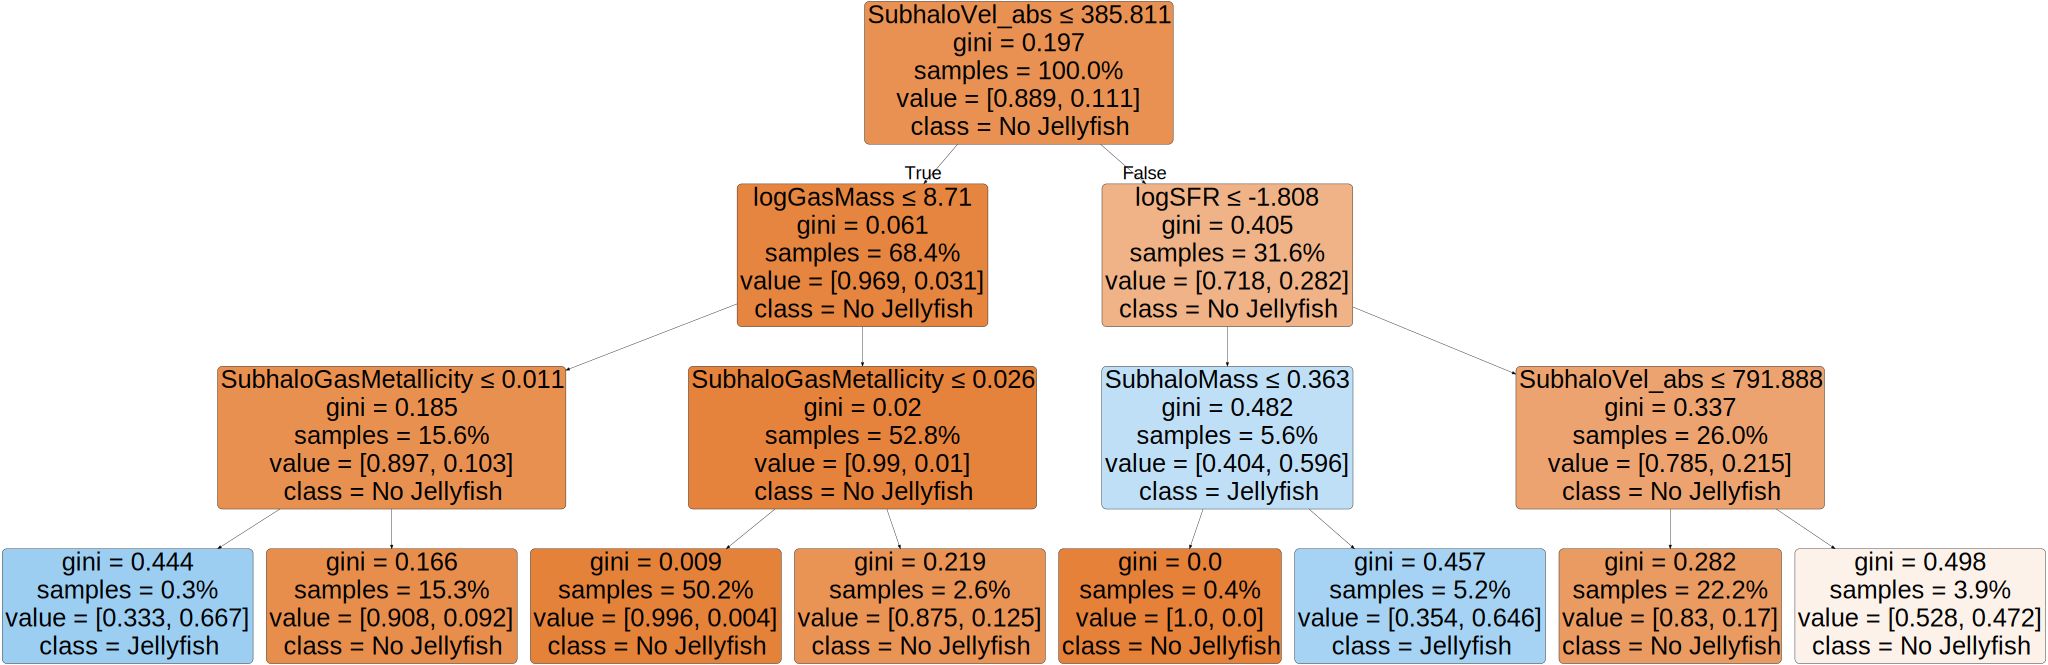

In [94]:
jelly_cols = [col for col in df_clean.columns if 'jelly' in col.lower()]
X_clf = df_clean.drop(columns=jelly_cols + ['SubhaloID'])
y_clf = df_clean['isJellyfish']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(Xc_train, yc_train)

y_pred_tree = tree_clf.predict(Xc_test)
cm_tree = confusion_matrix(yc_test, y_pred_tree)

print("Matriz de confusión (árbol de decisión):")
print(cm_tree)
print("\nReporte de clasificación:")
print(classification_report(yc_test, y_pred_tree))
print(f"\nF1-score Jellyfish: {f1_score(yc_test, y_pred_tree):.3f}")

dot_data = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=X_clf.columns,
    class_names=["No Jellyfish", "Jellyfish"],
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=3,
    special_characters=True
)

lines = dot_data.split("\n")
lines.insert(1, 'node [fontsize=69];')
lines.insert(2, 'edge [fontsize=50];')
lines.insert(3, 'graph [ranksep=1.5, nodesep=0.5];')
dot_data = "\n".join(lines)

graph = Source(dot_data)
graph.format = "png"
graph.render("decision_tree_graphviz", cleanup=True)
graph


# 3. 

In [34]:
# Quitamos columnas que no son predictoras
X = df_clean.drop(columns=['isJellyfish', 'SubhaloID'])
y = df_clean['isJellyfish']

# 20% de test, 80% de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

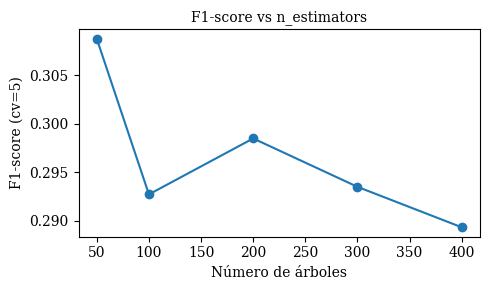

In [35]:
estimators = [50, 100, 200, 300, 400]
f1_scores = []

for n in estimators:
    rf_tmp = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    score = cross_val_score(rf_tmp, X_train, y_train, cv=5, scoring='f1')
    f1_scores.append(np.mean(score))

plt.figure(figsize=(5, 3))
plt.plot(estimators, f1_scores, marker='o')
plt.xlabel("Número de árboles")
plt.ylabel("F1-score (cv=5)")
plt.title("F1-score vs n_estimators")
plt.tight_layout()
plt.show()


In [36]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=4
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print(f"\nF1-score: {f1:.3f}")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\nMejores hiperparámetros:")
print(grid.best_params_)

y_pred_best = grid.best_estimator_.predict(X_test)
print("\nReporte con mejor modelo:")
print(classification_report(y_test, y_pred_best))

Matriz de confusión:
[[201   6]
 [ 20   6]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       207
           1       0.50      0.23      0.32        26

    accuracy                           0.89       233
   macro avg       0.70      0.60      0.63       233
weighted avg       0.86      0.89      0.87       233


F1-score: 0.316

Mejores hiperparámetros:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Reporte con mejor modelo:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       207
           1       0.55      0.23      0.32        26

    accuracy                           0.89       233
   macro avg       0.73      0.60      0.63       233
weighted avg       0.87      0.89      0.87       233



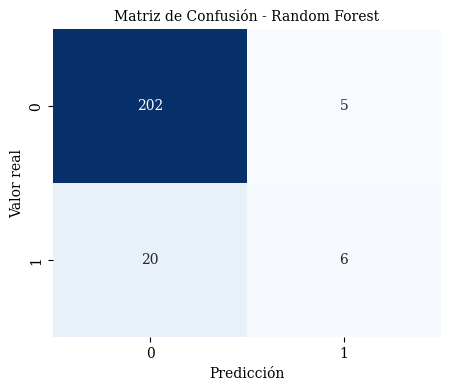

In [37]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


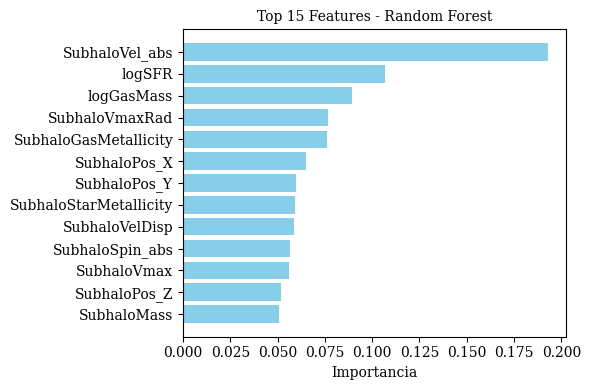

In [38]:
# Obtener importancia de features
importances = grid.best_estimator_.feature_importances_
features = X.columns

feat_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_df = feat_df.sort_values(by='importance', ascending=False).head(15)  # Top 15 features

plt.figure(figsize=(6, 4))
plt.barh(feat_df['feature'][::-1], feat_df['importance'][::-1], color='skyblue')
plt.xlabel("Importancia")
plt.title("Top 15 Features - Random Forest")
plt.tight_layout()
plt.show()


# 4.

In [39]:
list(df_clean.columns)

['SubhaloGasMetallicity',
 'SubhaloMass',
 'SubhaloPos_X',
 'SubhaloPos_Y',
 'SubhaloPos_Z',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloID',
 'isJellyfish',
 'logGasMass',
 'logSFR',
 'SubhaloSpin_abs',
 'SubhaloVel_abs']

In [40]:
# Predecir 'logSFR'
# Quitamos columnas que no son predictoras y las que no nos interesan
X = df_clean.drop(columns=['logSFR', 'SubhaloID', 'isJellyfish'])
y = df_clean['logSFR']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_reg = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_reg.fit(X_train, y_train)

print("\nMejores hiperparámetros:")
print(grid_reg.best_params_)

y_pred_best = grid_reg.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)  # √MSE
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print(f"R² del mejor modelo: {r2:.3f}")
print(f"RMSE del mejor modelo: {rmse:.3f}")
print(f"MAE del mejor modelo: {mae:.3f}")

RMSE: 0.240
MAE: 0.190
R²: 0.871

Mejores hiperparámetros:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
R² del mejor modelo: 0.868
RMSE del mejor modelo: 0.243
MAE del mejor modelo: 0.191


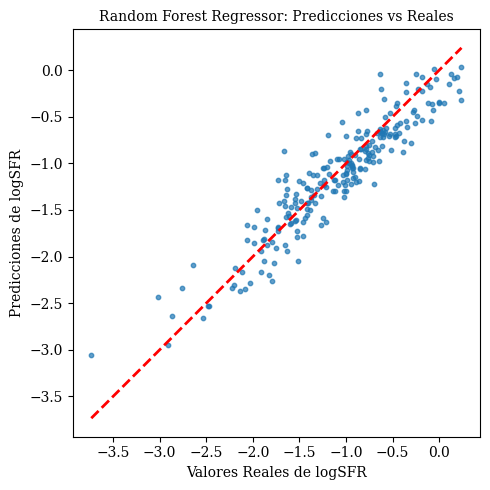

In [41]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_best, s=10, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Valores Reales de logSFR")
plt.ylabel("Predicciones de logSFR")
plt.title("Random Forest Regressor: Predicciones vs Reales")
plt.tight_layout()
plt.show()

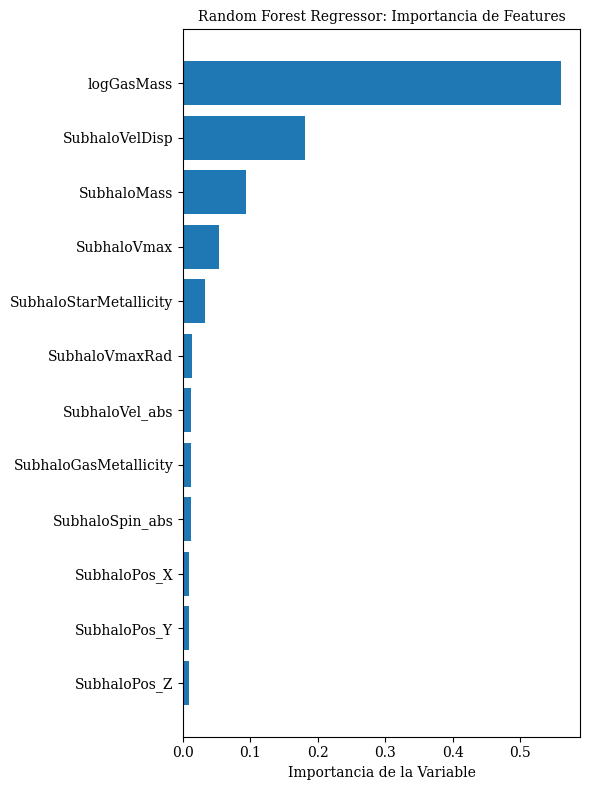

In [42]:
importances = grid_reg.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 8))
plt.barh(range(len(features)), importances[indices], align='center')
plt.yticks(range(len(features)), [features[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Importancia de la Variable")
plt.title("Random Forest Regressor: Importancia de Features")
plt.tight_layout()
plt.show()

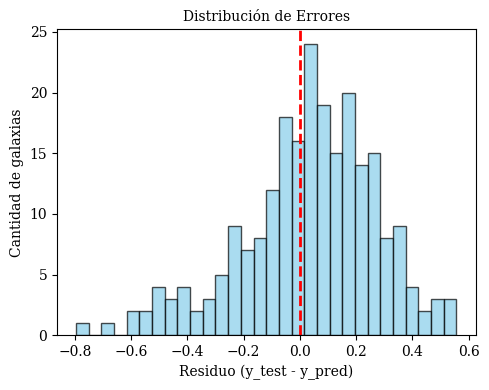

In [43]:
residuals = y_test - y_pred_best

plt.figure(figsize=(5, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Residuo (y_test - y_pred)")
plt.ylabel("Cantidad de galaxias")
plt.title("Distribución de Errores")
plt.tight_layout()
plt.show()

# 5.

In [44]:
features = df_clean.drop(columns=['isJellyfish', 'logSFR', 'SubhaloID'])
X = features.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_class = df_clean['isJellyfish'].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42
)

mlp_class = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)

mlp_class.fit(X_train_c, y_train_c)

y_pred_c = mlp_class.predict(X_test_c)
print("Clasificación - reporte:")
print(classification_report(y_test_c, y_pred_c))
print("Matriz de confusión:")
print(confusion_matrix(y_test_c, y_pred_c))


y_reg = df_clean['logSFR'].values

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_scaled, y_reg, test_size=0.2, random_state=42
)

mlp_reg = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)

mlp_reg.fit(X_train_r, y_train_r)

y_pred_r = mlp_reg.predict(X_test_r)
mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_r, y_pred_r)

print(f"Regresión - RMSE: {rmse:.3f}, R²: {r2:.3f}")

/home/2025/AST0421-1/svtroncoso/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Clasificación - reporte:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       207
           1       0.39      0.42      0.41        26

    accuracy                           0.86       233
   macro avg       0.66      0.67      0.66       233
weighted avg       0.87      0.86      0.86       233

Matriz de confusión:
[[190  17]
 [ 15  11]]
Regresión - RMSE: 0.291, R²: 0.812


/home/2025/AST0421-1/svtroncoso/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


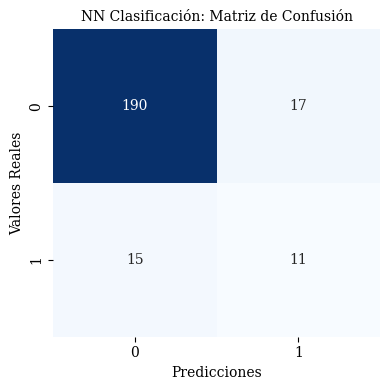

In [45]:
cm = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("NN Clasificación: Matriz de Confusión")
plt.tight_layout()
plt.show()

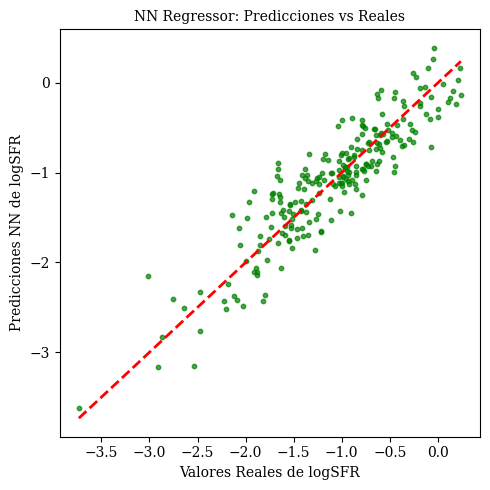

In [46]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test_r, y_pred_r, s=10, alpha=0.7, color='green')
plt.plot([y_test_r.min(), y_test_r.max()],
         [y_test_r.min(), y_test_r.max()],
         'r--', lw=2)
plt.xlabel("Valores Reales de logSFR")
plt.ylabel("Predicciones NN de logSFR")
plt.title("NN Regressor: Predicciones vs Reales")
plt.tight_layout()
plt.show()

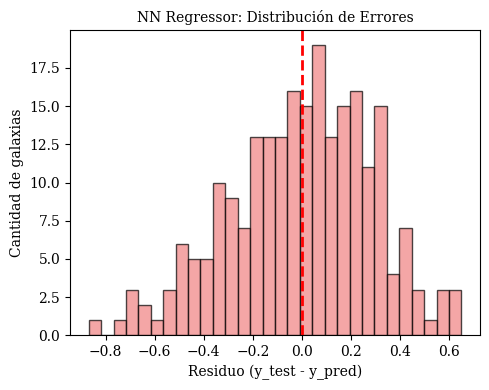

In [47]:
residuals = y_test_r - y_pred_r
plt.figure(figsize=(5, 4))
plt.hist(residuals, bins=30, color='lightcoral', edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Residuo (y_test - y_pred)")
plt.ylabel("Cantidad de galaxias")
plt.title("NN Regressor: Distribución de Errores")
plt.tight_layout()
plt.show()

# 6. 

In [48]:
features = df_clean.drop(columns=['isJellyfish', 'logSFR', 'SubhaloID'])
X = features.values
feature_names = features.columns

y_class = df_clean['isJellyfish'].values

y_reg = df_clean['logSFR'].values

rf_class = RandomForestClassifier(n_estimators=200, random_state=42)
rf_class.fit(X, y_class)
importances_class = rf_class.feature_importances_

rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X, y_reg)
importances_reg = rf_reg.feature_importances_

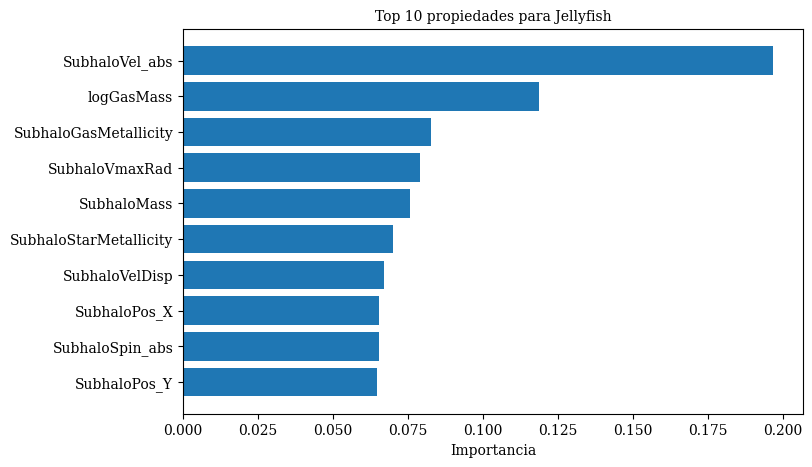

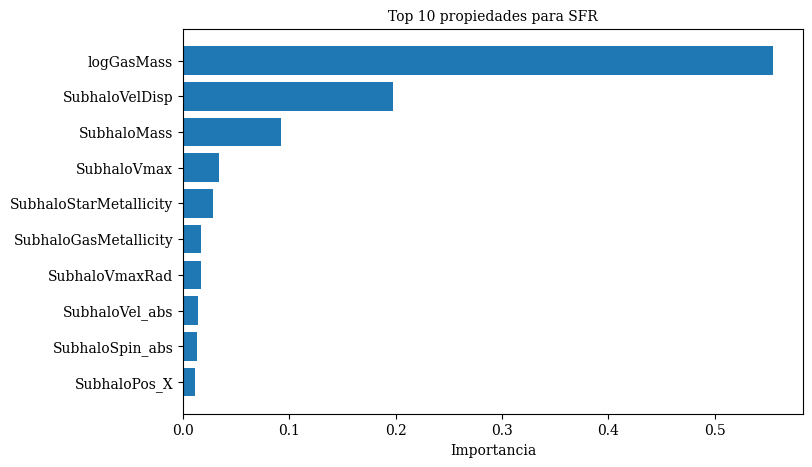

In [49]:
def plot_importances(importances, names, top=10, title="Importancia de variables"):
    idx = np.argsort(importances)[::-1][:top]
    plt.figure(figsize=(8,5))
    plt.barh(range(top), importances[idx][::-1], align='center')
    plt.yticks(range(top), names[idx][::-1])
    plt.xlabel("Importancia")
    plt.title(title)
    plt.show()


plot_importances(importances_class, feature_names, top=10, title="Top 10 propiedades para Jellyfish")
plot_importances(importances_reg, feature_names, top=10, title="Top 10 propiedades para SFR")

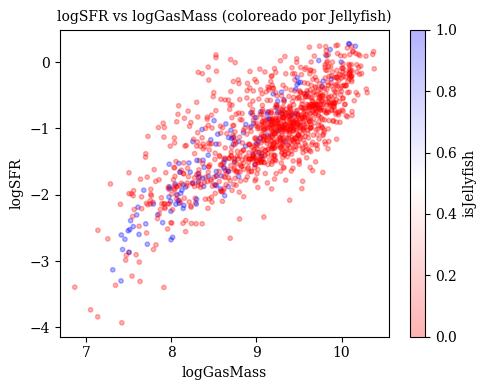

In [50]:
# Tomamos la propiedad más importante según RF regresor
top_feature = feature_names[np.argmax(importances_reg)]

plt.figure(figsize=(5,4))
plt.scatter(df_clean[top_feature], df_clean['logSFR'], c=df_clean['isJellyfish'],
            cmap='bwr_r', s=10, alpha=0.3)
plt.xlabel(top_feature)
plt.ylabel("logSFR")
plt.title(f"logSFR vs {top_feature} (coloreado por Jellyfish)")
plt.colorbar(label="isJellyfish")
plt.tight_layout()
plt.show()

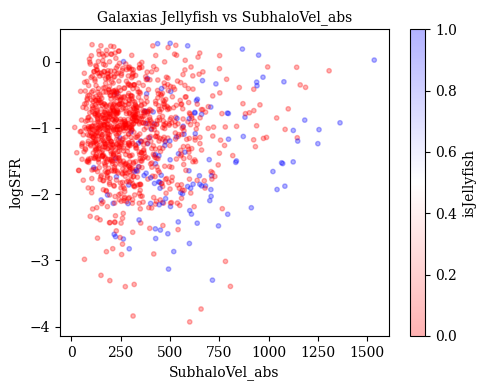

In [51]:
top_feature_class = feature_names[np.argmax(importances_class)]

plt.figure(figsize=(5,4))
plt.scatter(df_clean[top_feature_class], df_clean['logSFR'], c=df_clean['isJellyfish'],
            cmap='bwr_r', s=10, alpha=0.3)
plt.xlabel(top_feature_class)
plt.ylabel("logSFR")
plt.title(f"Galaxias Jellyfish vs {top_feature_class}")
plt.colorbar(label="isJellyfish")
plt.tight_layout()
plt.show()


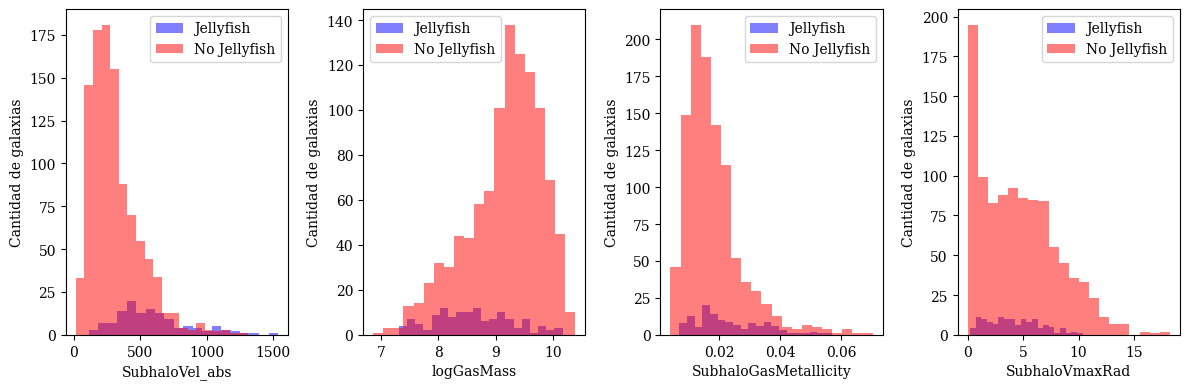

In [52]:
top_features_class = feature_names[np.argsort(importances_class)[::-1][:4]]  # top 4
plt.figure(figsize=(12,4))

for i, feat in enumerate(top_features_class):
    plt.subplot(1,4,i+1)
    plt.hist(df_clean.loc[df_clean['isJellyfish']==1, feat], bins=20, alpha=0.5, label='Jellyfish', color='blue')
    plt.hist(df_clean.loc[df_clean['isJellyfish']==0, feat], bins=20, alpha=0.5, label='No Jellyfish', color='red')
    plt.xlabel(feat)
    plt.ylabel("Cantidad de galaxias")
    plt.legend()

plt.tight_layout()
plt.show()

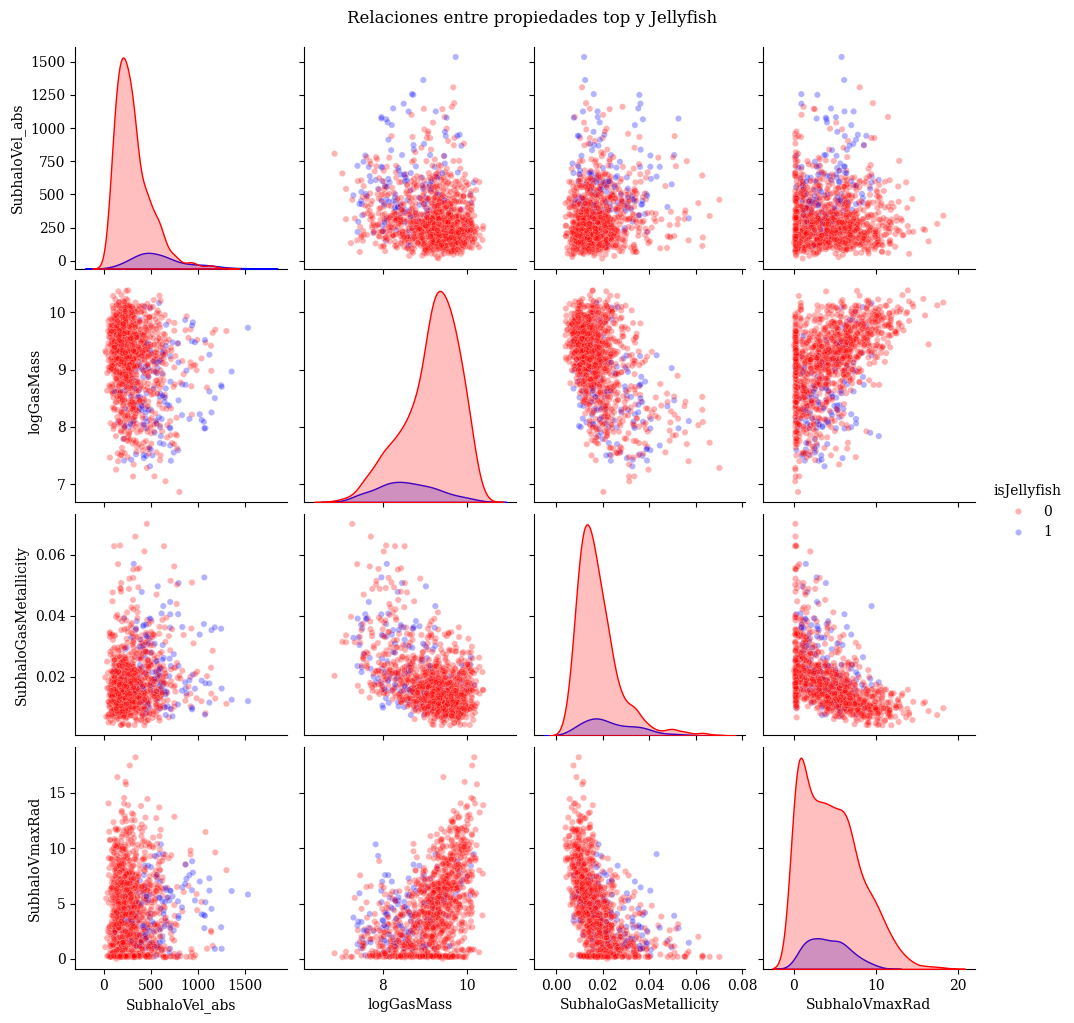

In [53]:
# Seleccionamos top 4 propiedades del RF de clasificación
top_features = feature_names[np.argsort(importances_class)[::-1][:4]]
df_plot = df_clean[top_features.tolist() + ['isJellyfish']]

sns.pairplot(df_plot, hue='isJellyfish', palette={0:'red', 1:'blue'}, diag_kind='kde', plot_kws={'alpha':0.3, 's':20})
plt.suptitle("Relaciones entre propiedades top y Jellyfish", y=1.02)
plt.show()


/tmp/ipykernel_1726671/1133309729.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isJellyfish_str', y=feat, data=df_clean, palette={'0':'red','1':'blue'})


<Axes: xlabel='isJellyfish_str', ylabel='SubhaloVmaxRad'>

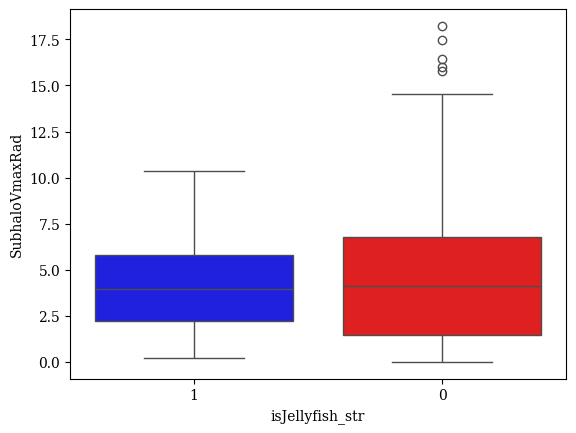

In [54]:
df_clean['isJellyfish_str'] = df_clean['isJellyfish'].astype(str)
sns.boxplot(x='isJellyfish_str', y=feat, data=df_clean, palette={'0':'red','1':'blue'})


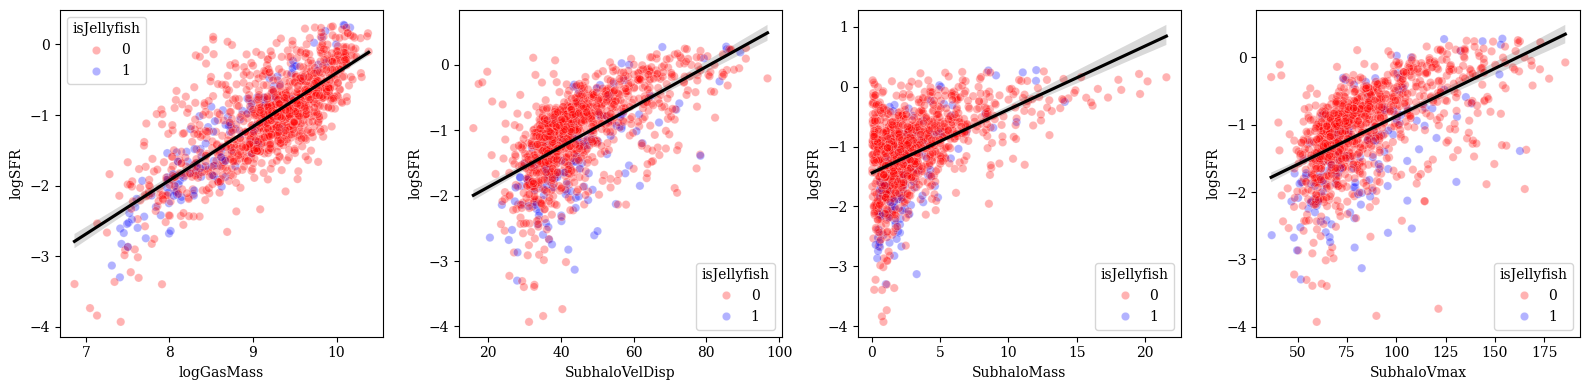

In [55]:
top_features_reg = feature_names[np.argsort(importances_reg)[::-1][:4]]

plt.figure(figsize=(16,4))
for i, feat in enumerate(top_features_reg):
    plt.subplot(1,4,i+1)
    sns.scatterplot(x=feat, y='logSFR', hue=df_clean['isJellyfish'].astype(int), 
                    palette={0:'red', 1:'blue'}, data=df_clean, alpha=0.3)
    sns.regplot(x=feat, y='logSFR', data=df_clean, scatter=False, color='black')  # sin lowess
    plt.xlabel(feat)
    plt.ylabel('logSFR')
plt.tight_layout()
plt.show()


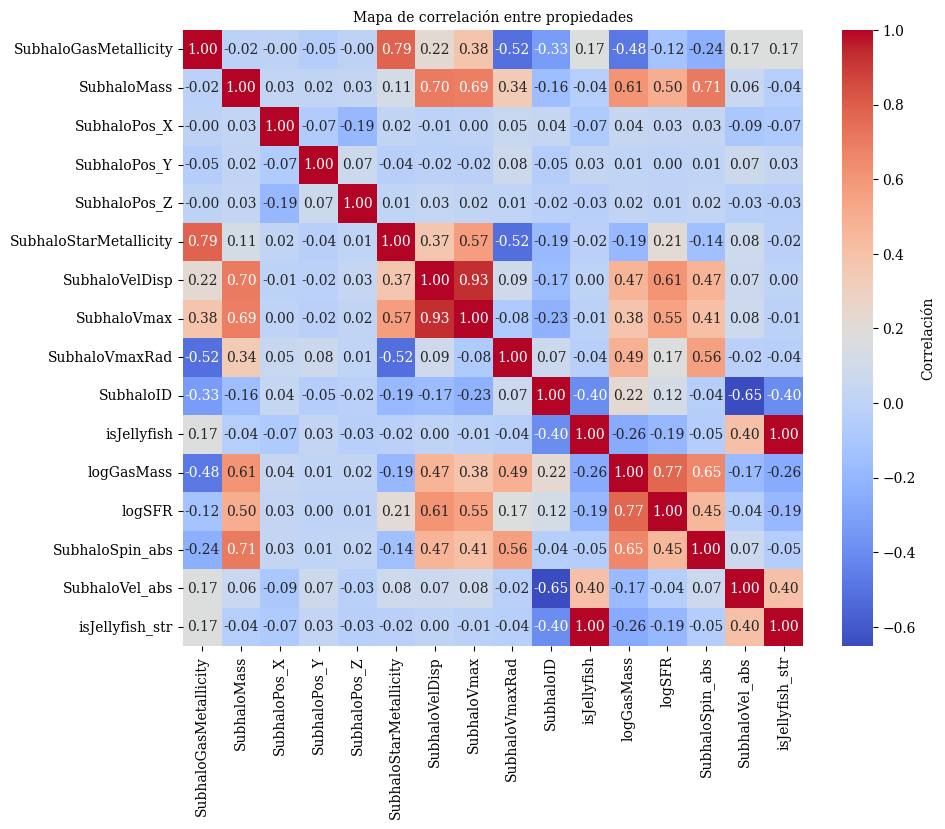

In [56]:
plt.figure(figsize=(10,8))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label':'Correlación'})
plt.title("Mapa de correlación entre propiedades")
plt.show()
